## SVM for image classification
[readmore](https://rpubs.com/Sharon_1684/454441)

Code are based on [here](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/)

## Setting up

In [3]:
import pandas as pd
import os

from skimage.transform import resize
from skimage.io import imread
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT
from skimage import transform


import skimage

import numpy as np
import matplotlib.pyplot as plt

import joblib
from tqdm import tqdm
from collections import Counter
from PIL import Image 

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../../scripts/')

from svm_functions import resize_all, RGB2GrayTransformer, HogTransformer


%matplotlib inline

In [11]:
repo_name = 'Respiratory_Disease_Classification'
cwd_path = os.getcwd()
src = os.listdir(train_dir)[1:]

## Re-size train and validation images
save the resized image into pkl data for later loading.

In [12]:
base_name_train = 'spectrogram_train'
width = 80
include = src
train_dir = cwd_path.split(repo_name, 1)[0]+repo_name+"/data/images/90-10_split_new/cls_2/train"

resize_all(src=train_dir,pklname=base_name_train, width=width, include=src)

health_0


100%|██████████| 1904/1904 [00:45<00:00, 41.90it/s]


In [13]:
base_name_val = 'spectrogram_val'
val_dir = cwd_path.split(repo_name, 1)[0]+repo_name+"/data/images/90-10_split_new/cls_2/val"

resize_all(src=val_dir,pklname=base_name_val, width=width, include=src)

health_0


100%|██████████| 606/606 [00:14<00:00, 40.64it/s]


In [14]:
base_name_test = 'spectrogram_test'
test_dir = cwd_path.split(repo_name, 1)[0]+repo_name+"/data/images/90-10_split_new/cls_2/train"

# resize_all(src=train_dir,pklname=base_name_test, width=width, include=src)

Information on the data exported

In [7]:
data_train = joblib.load(f'{base_name_train}_{width}x{width}px.pkl')
data_val = joblib.load(f'{base_name_val}_{width}x{width}px.pkl')
data_test = joblib.load(f'{base_name_test}_{width}x{width}px.pkl')
 
print('number of training samples: ', len(data_train['data']))
print('number of validation samples: ', len(data_val['data']))
print('number of validation samples: ', len(data_test['data']))

print('keys: ', list(data_train.keys()))
print('description: ', data_train['description'])
print('image shape: ', data_train['data'][0].shape)
print('labels:', np.unique(data_train['label']))
 
print("Training data",Counter(data_train['label']))
print("Validation data", Counter(data_val['label']))
print("Test data", Counter(data_test['label']))

number of training samples:  2491
number of validation samples:  998
number of validation samples:  2072
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['0' '1']
Training data Counter({'0': 1508, '1': 983})
Validation data Counter({'0': 674, '1': 324})
Test data Counter({'0': 1345, '1': 727})


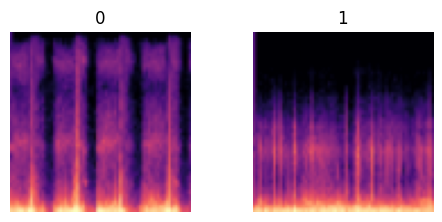

In [8]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data_train['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(5,3)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data_train['label'].index(label)
     
    ax.imshow(data_train['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [9]:
# Define Train-Test, use validation data for testing
X_train = np.array(data_train['data'])
y_train = np.array(data_train['label'])
X_test = np.array(data_val['data'])
y_test = np.array(data_val['label'])


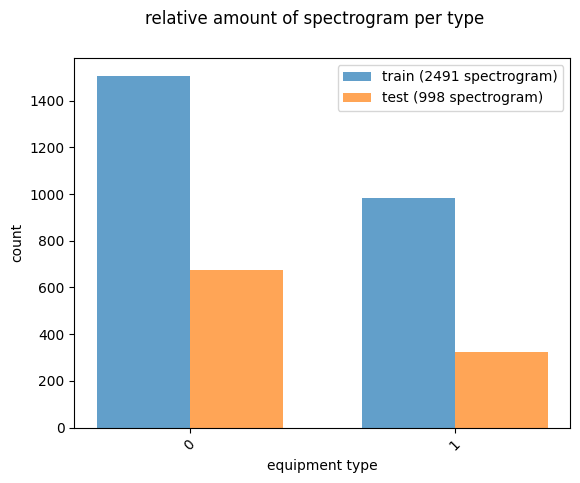

In [10]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of spectrogram per type')
plot_bar(y_train, loc='left', relative=False)
plot_bar(y_test, loc='right', relative=False)
plt.legend([
    'train ({0} spectrogram)'.format(len(y_train)), 
    'test ({0} spectrogram)'.format(len(y_test))
])

### HOG-SVM example

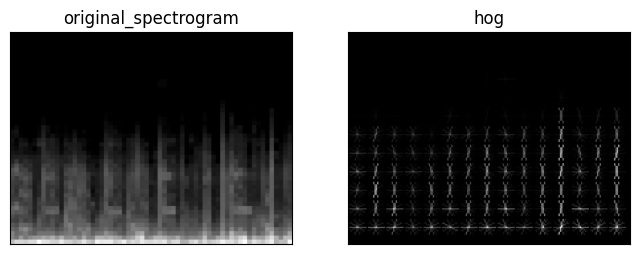

In [11]:
img_path = "../../data/images/90-10_split/test/health_0/0_f1_3464.png"

spec = imread(img_path, as_gray=True)
 
# scale down the image to one third
spec_gray = rescale(spec, 1/3, mode='reflect')

# calculate the hog and return a visual representation.
spec_hog, spec_hog_img = hog(
            spec_gray, pixels_per_cell=(14,14), 
            cells_per_block=(2, 2), 
            orientations=9, 
            visualize=True, 
            block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,8)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]

ax[0].imshow(spec, cmap='gray')
ax[0].set_title('original_spectrogram')
ax[1].imshow(spec_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [12]:
print('number of pixels: ', spec.shape[0] * spec.shape[1])
print('number of hog features: ', spec_hog.shape[0])

number of pixels:  307200
number of hog features:  5040


HOG Transformers
- Color images to gray scale
- Calculate HOGs
- Scale the data

In [13]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(2491, 576)


### SIFT

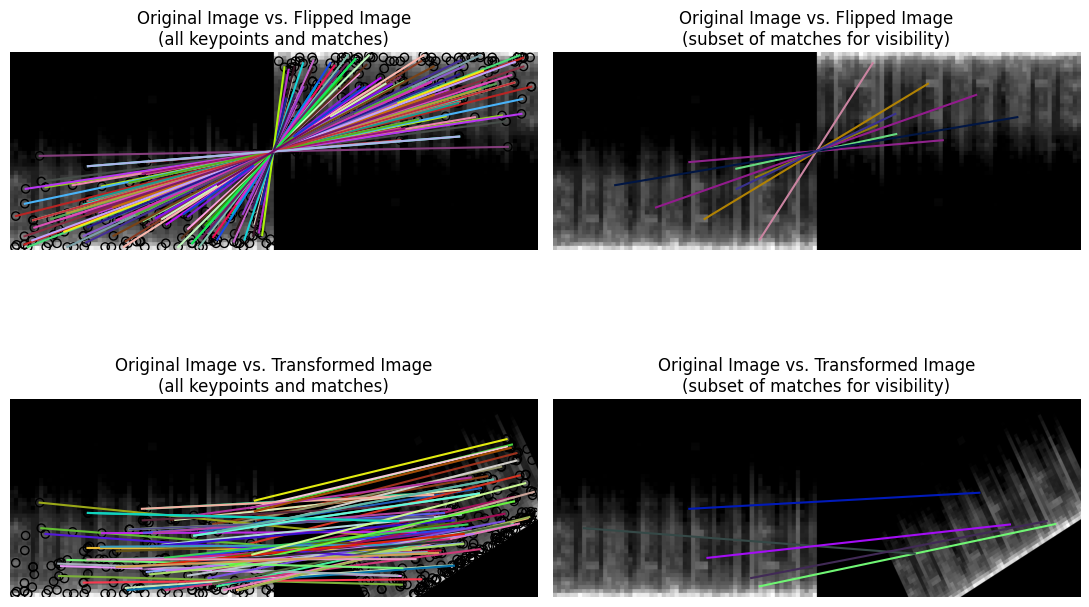

In [14]:
img1 = spec
img2 = transform.rotate(img1, 180)
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                                  translation=(0, -200))
img3 = transform.warp(img1, tform)

descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.6,
                              cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, max_ratio=0.6,
                              cross_check=True)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))

plt.gray()

plot_matches(ax[0, 0], img1, img2, keypoints1, keypoints2, matches12)
ax[0, 0].axis('off')
ax[0, 0].set_title("Original Image vs. Flipped Image\n"
                   "(all keypoints and matches)")

plot_matches(ax[1, 0], img1, img3, keypoints1, keypoints3, matches13)
ax[1, 0].axis('off')
ax[1, 0].set_title("Original Image vs. Transformed Image\n"
                   "(all keypoints and matches)")

plot_matches(ax[0, 1], img1, img2, keypoints1, keypoints2, matches12[::15],
             only_matches=True)
ax[0, 1].axis('off')
ax[0, 1].set_title("Original Image vs. Flipped Image\n"
                   "(subset of matches for visibility)")

plot_matches(ax[1, 1], img1, img3, keypoints1, keypoints3, matches13[::15],
             only_matches=True)
ax[1, 1].axis('off')
ax[1, 1].set_title("Original Image vs. Transformed Image\n"
                   "(subset of matches for visibility)")

plt.tight_layout()
plt.show()

## Model Training

In [15]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

## Testing

In [16]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

## Evaluation

In [17]:
y_pred = sgd_clf.predict(X_test_prepared)

print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  74.14829659318637


### Confusion Matrix

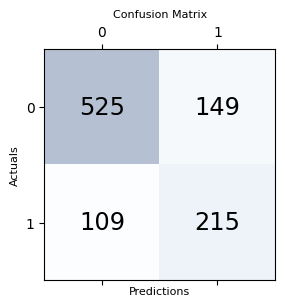

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=8)
plt.ylabel('Actuals', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       674
           1       0.59      0.66      0.62       324

    accuracy                           0.74       998
   macro avg       0.71      0.72      0.71       998
weighted avg       0.75      0.74      0.75       998



## Pipeline

In [24]:
from sklearn.pipeline import Pipeline
from sklearn import svm

In [21]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  74.14829659318637


## Grid Search

In [25]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

In [26]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [28]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl')

['hog_sgd_model.pkl']

In [29]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SGDClassifier(random_state=42))])

In [30]:
# the highscore during the search
grid_res.best_score_

0.8631102025430241

In [31]:
print(grid_res.best_params_)

{'hogify__cells_per_block': (3, 3), 'hogify__orientations': 8, 'hogify__pixels_per_cell': (8, 8)}


In [32]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  78.3567134268537


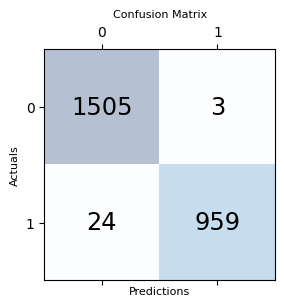

In [33]:
cm_gridS = confusion_matrix(y_train, grid_res.predict(X_train))

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm_gridS, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm_gridS.shape[0]):
    for j in range(cm_gridS.shape[1]):
        ax.text(x=j, y=i,s=cm_gridS[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=8)
plt.ylabel('Actuals', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.show()

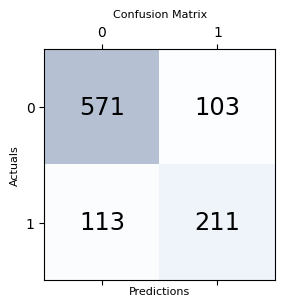

In [35]:
cm_gridS = confusion_matrix(y_test, best_pred)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm_gridS, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm_gridS.shape[0]):
    for j in range(cm_gridS.shape[1]):
        ax.text(x=j, y=i,s=cm_gridS[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=8)
plt.ylabel('Actuals', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.show()


In [36]:
cm_gridS

array([[571, 103],
       [113, 211]])

In [45]:
print(classification_report(y_test, best_pred))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       674
           1       0.65      0.78      0.71       324

    accuracy                           0.79       998
   macro avg       0.77      0.79      0.78       998
weighted avg       0.81      0.79      0.80       998

